In [5]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.0 MB/s eta 0:00:00


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.io import read_image
import glob
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
checkpoint = torch.load('/content/drive/MyDrive/792_model/CelebDF_model_20_epochs_99acc.pt',map_location=torch.device('cpu'))
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [70]:
class CustomDataset(Dataset):
	def __init__(self, transform=None):
		self.imgs_path = '/content/drive/MyDrive/Celeb_DF_dataset/'
		self.transform = transform
		file_list = glob.glob(self.imgs_path + "*")
		
		self.data = []
		for class_path in file_list:
			# class_name = class_path.split("\\")[-1]
			class_name = class_path.split("/")[-1]
			print(class_name)
			for img_path in glob.glob(class_path + "/*.jpg"):
				self.data.append([img_path, class_name])
			
		self.class_map = {"Celeb-real-images": 0, "Celeb-synthetic-images": 1}
	
	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		img_path, class_name = self.data[idx]
		img = read_image(img_path)
		class_id = self.class_map[class_name]
		class_id = torch.tensor([class_id])

		# Transform if necessary
		if self.transform:
				img_tensor = self.transform(img)
		return img_tensor, class_id

In [71]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
     ])

In [75]:
dataset = CustomDataset(transform=train_transforms)
train_size = int(0.96 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])	

Celeb-synthetic-images
Celeb-real-images


In [76]:
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_data_loader)

469

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [78]:
model.eval()
predicted_labels = []
actual_labels = []

with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        output = torch.sigmoid(output)
        predicted_label = (output > 0.5).int()
        predicted_labels.append(predicted_label.item())
        actual_labels.append(labels.item())
        print (output.item(), '     ',predicted_label)

1.0       tensor([[1]], dtype=torch.int32)
0.9999998807907104       tensor([[1]], dtype=torch.int32)
8.632626304461155e-06       tensor([[0]], dtype=torch.int32)
0.9999995231628418       tensor([[1]], dtype=torch.int32)
0.9999996423721313       tensor([[1]], dtype=torch.int32)
0.9999966621398926       tensor([[1]], dtype=torch.int32)
0.9999996423721313       tensor([[1]], dtype=torch.int32)
0.9999991655349731       tensor([[1]], dtype=torch.int32)
1.7727599388450699e-09       tensor([[0]], dtype=torch.int32)
0.9999995231628418       tensor([[1]], dtype=torch.int32)
0.9999998807907104       tensor([[1]], dtype=torch.int32)
6.3819079514360055e-06       tensor([[0]], dtype=torch.int32)
9.488747309660539e-06       tensor([[0]], dtype=torch.int32)
0.9999992847442627       tensor([[1]], dtype=torch.int32)
3.75263113028268e-07       tensor([[0]], dtype=torch.int32)
0.9999980926513672       tensor([[1]], dtype=torch.int32)
0.9999974966049194       tensor([[1]], dtype=torch.int32)
7.56927511247

In [79]:
predicted_labels[:20]

[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]

In [80]:
actual_labels[:20]

[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]

In [81]:
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       186
           1       1.00      0.99      0.99       283

    accuracy                           0.99       469
   macro avg       0.99      0.99      0.99       469
weighted avg       0.99      0.99      0.99       469



Precision:  1.0
Recall:  0.9893992932862191
F1 score:  0.9946714031971582


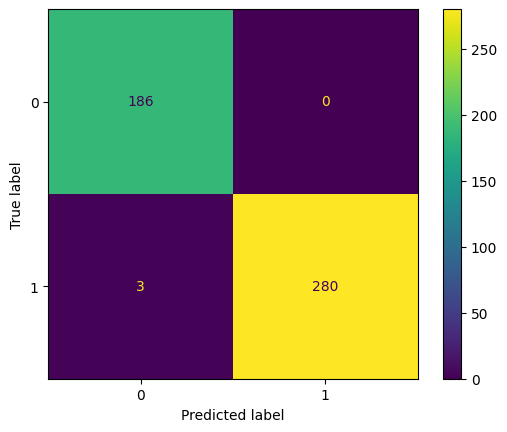

In [82]:
# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Compute precision and recall
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
precision = tp / (tp + fp)
print("Precision: ", precision)

recall = tp / (tp + fn)
print("Recall: ",recall)
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 score: ",f1_score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

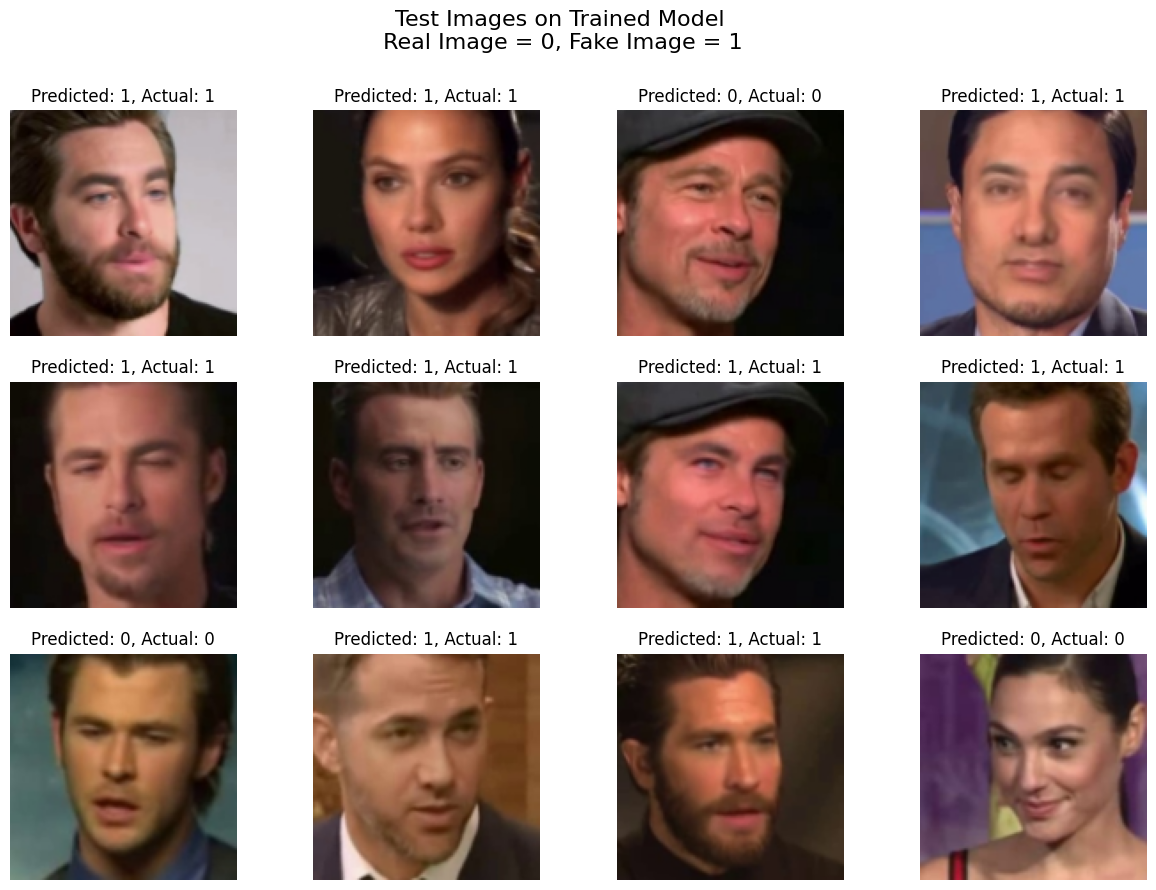

In [84]:
predicted_labels = np.array(predicted_labels)
actual_labels = np.array(actual_labels)
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Test Images on Trained Model\n Real Image = 0, Fake Image = 1', fontsize=16)
for i, (data, label) in enumerate(test_data_loader):
    ax = axs[i//4, i%4]
    ax.imshow(np.transpose(data.squeeze().numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f'Predicted: {predicted_labels[i]}, Actual: {actual_labels[i]}')
    if i == 11:
        break

plt.show()